In [6]:
from devito import *
import numpy as np
import matplotlib.pyplot as plt

from examples.seismic import SeismicModel, plot_velocity, demo_model
from examples.seismic.source import RickerSource, Receiver, TimeAxis

In [7]:
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [8]:
shape = (1001, 121, 361)
spacing = (5., 5., 5) 
origin = (0, 0, 0)
nbl = 40
so = 8

model = demo_model('layers-isotropic',
                   origin=origin,
                   spacing=spacing,
                   shape=shape,
                   so=so,
                   nbl=nbl)

Operator `initdamp` ran in 0.10 s


In [9]:
model.domain_size

(np.float32(5000.0), np.float32(600.0), np.float32(1800.0))

In [10]:
t0, tn = 0., 1000.
dt = model.critical_dt 
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid = model.grid, f0=0.015, time_range=time_range)
src.coordinates.data[:] = [2500, 2500, 0] 

# Now we create the velocity and pressure fields
p = TimeFunction(name='p', grid=model.grid, staggered=NODE, space_order=so, time_order=2)
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=2)


# The source injection term
src_p = src.inject(field=p.forward, expr=src)

# The receiver
nrec = 12000

rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
for i in range(12):
    rec.coordinates.data[i*1000:i*1000+1000,0] = np.linspace(0, 5000, 1001)
    rec.coordinates.data[i*1000:i*1000+1000,1] = i*50
    rec.coordinates.data[i*1000:i*1000+1000,2] = 0

rec_term = rec.interpolate(expr=v[2])

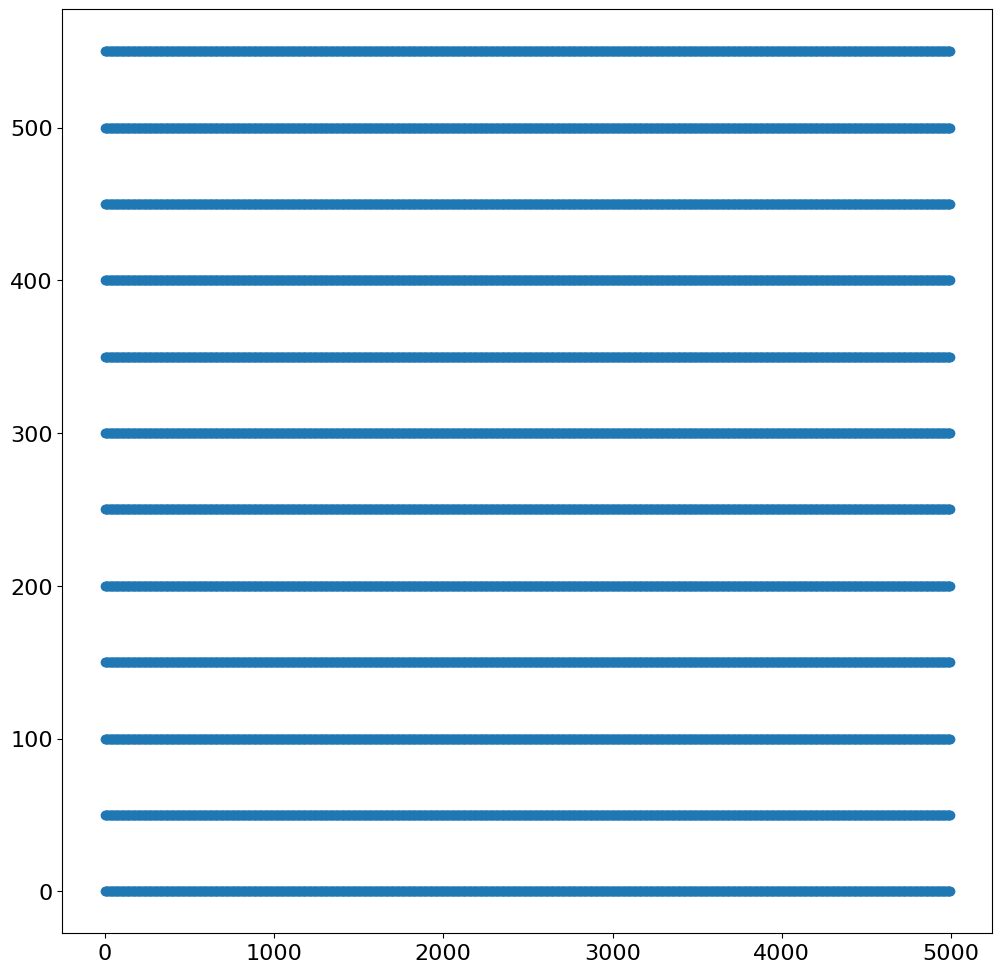

In [26]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
ax.scatter(rec.coordinates.data[:,0], rec.coordinates.data[:,1])

In [6]:
# We need some initial conditions
V_p = 1.5
density = 1.

ro = 1/density
l2m = V_p*V_p*density

#2nd order acoustic according to fdelmoc
u_v_2 = Eq(v.forward, solve(v.dt - ro * grad(p), v.forward))
u_p_2 = Eq(p.forward, solve(p.dt - l2m * div(v.forward), p.forward))

In [9]:
op_2 = Operator([u_v_2, u_p_2]+src_p+rec_term)

In [19]:
op_2(time=src.time_range.num-1, dt=dt)

/usr/bin/ld: warning: /tmp/pgcudafat9oMb3nUHjP6c.o: missing .note.GNU-stack section implies executable stack
/usr/bin/ld: NOTE: This behaviour is deprecated and will be removed in a future version of the linker
Operator `Kernel` ran in 59.19 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=57.49033000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.1369700000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.04027299999999974, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [24]:
rec.data.T.reshape(12,1000,1401).shape

(12, 1000, 1401)

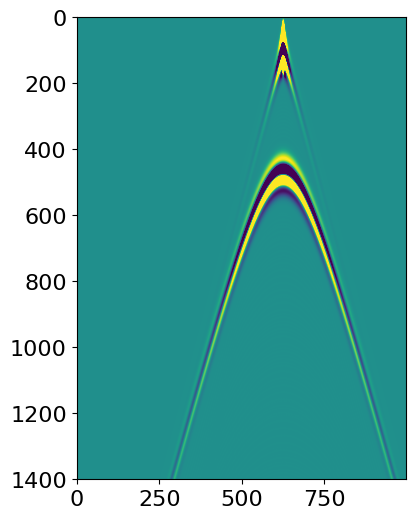

In [24]:
plt.imshow(rec.data, vmin=-0.001, vmax=0.001)

# Подсчет Алокаций

In [10]:
rec.data.shape

(1401, 1000)

In [40]:
#Размер ячейки 5м
size = (3, 1081, 201, 441)
v_size = 3*np.prod(size)*(4)/1024/1024
p_size = np.prod(size)*(4)/1024/1024
rec_size = np.prod(rec.data.shape)*(rec.data.dtype.itemsize)/1024/1024
v_size+p_size+rec_size

np.float64(4450.466354370117)

In [41]:
#Размер ячейки 4м
size = (3, 1331, 231, 531)
v_size = 3*np.prod(size)*(4)/1024/1024
p_size = np.prod(size)*(4)/1024/1024
rec_size = np.prod(rec.data.shape)*(rec.data.dtype.itemsize)/1024/1024
v_size+p_size+rec_size

np.float64(7537.66438293457)

In [14]:
#Размер ячейки 2.5м
size = (3, 2081, 321, 801)
v_size = 3*np.prod(size)*(4)/1024/1024
p_size = np.prod(size)*(4)/1024/1024
rec_size = np.prod(rec.data.shape)*(rec.data.dtype.itemsize)/1024/1024
v_size+p_size+rec_size

np.float64(24557.638595581055)

In [13]:
#Размер ячейки 2м
size = (3, 2581, 381, 981)
v_size = 3*np.prod(size)*(4)/1024/1024
p_size = np.prod(size)*(4)/1024/1024
rec_size = np.prod(rec.data.shape)*(rec.data.dtype.itemsize)/1024/1024
v_size+p_size+rec_size

np.float64(44223.5477142334)

Вынос 1000м

In [15]:
#Размер ячейки 4м
size = (3, 831, 581, 531)
v_size = 3*np.prod(size)*(4)/1024/1024
p_size = np.prod(size)*(4)/1024/1024
rec_size = np.prod(rec.data.shape)*(rec.data.dtype.itemsize)/1024/1024
v_size+p_size+rec_size

np.float64(11741.152542114258)

In [16]:
#Размер ячейки 2.5м
size = (3, 1281, 881, 1001)
v_size = 3*np.prod(size)*(4)/1024/1024
p_size = np.prod(size)*(4)/1024/1024
rec_size = np.prod(rec.data.shape)*(rec.data.dtype.itemsize)/1024/1024
v_size+p_size+rec_size

np.float64(51718.42854309082)

In [5]:
#Размер ячейки 2м
size = (3, 1581, 381, 981)
v_size = 3*np.prod(size)*(4)/1024/1024
p_size = np.prod(size)*(4)/1024/1024
rec_size = np.prod(rec.data.shape)*(rec.data.dtype.itemsize)/1024/1024
v_size+p_size+rec_size

NameError: name 'rec' is not defined

In [18]:
p_size + v_size + rec_size

np.float64(76753.4907989502)